## Example
We show a simple example using a single layer neural network, which shows that priviledged information can be used to improve learning. Our example is a simple 2-D spiral distributed data (not linearly separable).
However, if we know the polar parameters as priviledged information, then the dataset is separable.
We estimate the difficulty of examples from the priviledged information and use that to change the learning rate of examples. This improves the test case accuracy of the algorithm!

In [1]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Generate data
We generate 3 different classes of data, distributed in a spiral shape as shown below:

(-1, 1)

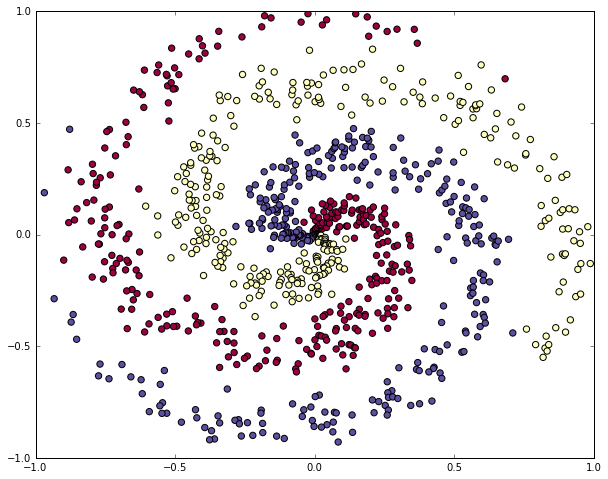

In [2]:
np.random.seed(0)
N = 300 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
rot = 1;
X = np.zeros((N*K,D))
polar = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in xrange(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = 2*np.pi*j/K + r*2*np.pi*rot + np.random.randn(N)*0.4 # theta
  polar[ix] = np.c_[r,t]
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
#fig.savefig('spiral_raw.png')

### Priviledged Information
The priviledged information is the polar (r,theta) data which was used to generate the spiral.
Notice that, the polar coordinates contains more information because, we can never know if theta, or theta+2*pi etc..

We plot the priviledged information below. As we see, it is very easy even with a less strong linear classifier (0-layer NN) to obtain good classification over the priviledged class

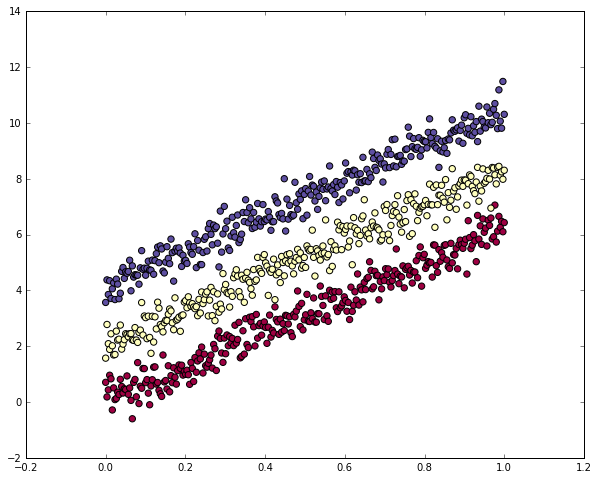

In [3]:
fig = plt.figure()
#plt.scatter(r,t,c=y)
plt.scatter(polar[:,0], polar[:,1], c=y, s=40, cmap=plt.cm.Spectral)

## Step 1 : Obtain weights from the priviledged data
We train a linear classifier and obtain the class probabilities using a softmax layer at the end.
The max class probability serves as the difficulty of the example.

In [4]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 4e-1
reg = 1e-4 # regularization strength

# gradient descent loop
num_examples = polar.shape[0]
for i in xrange(4000):
  
  # evaluate class scores, [N x K]
  scores = np.dot(polar, W) + b 
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print "iteration %d: loss %f" % (i, loss)
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(polar.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)
  
  dW += reg*W # regularization gradient
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

iteration 0: loss 1.089406
iteration 1000: loss 0.360889
iteration 2000: loss 0.165499
iteration 3000: loss 0.148236


In [5]:
# evaluate training set accuracy
scores = np.dot(polar, W) + b
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.99


In [6]:
scores = np.dot(polar, W) + b
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
diff_level = np.max(scores, axis=1).reshape((N*K,1))

(-1.6009159726761339, 12.479084027323879)

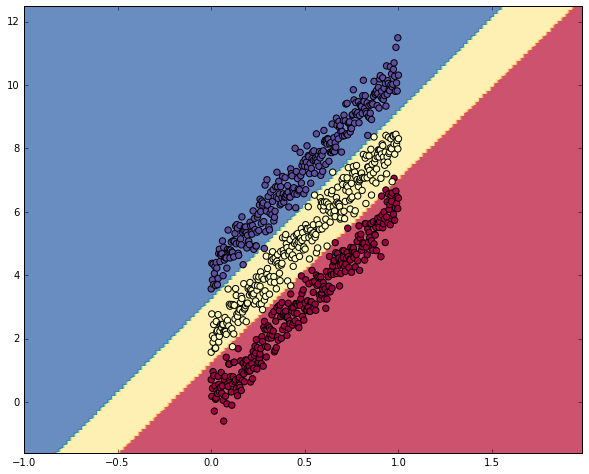

In [7]:
# plot the resulting classifier
h = 0.02
x_min, x_max = polar[:, 0].min() - 1, polar[:, 0].max() + 1
y_min, y_max = polar[:, 1].min() - 1, polar[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(polar[:, 0], polar[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

In [8]:
W_polar = W
b_polar = b

### Training without priviledged information
For a reference, we train without using priviledged information ( for 20000 epochs!)

In [9]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-1
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in xrange(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print "iteration %d: loss %f" % (i, loss)
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples

  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098625
iteration 1000: loss 1.016405
iteration 2000: loss 0.949856
iteration 3000: loss 0.850116
iteration 4000: loss 0.773526
iteration 5000: loss 0.687408
iteration 6000: loss 0.628267
iteration 7000: loss 0.596520
iteration 8000: loss 0.577197
iteration 9000: loss 0.562168


In [10]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.86


(-1.9292686205935685, 1.9707313794064349)

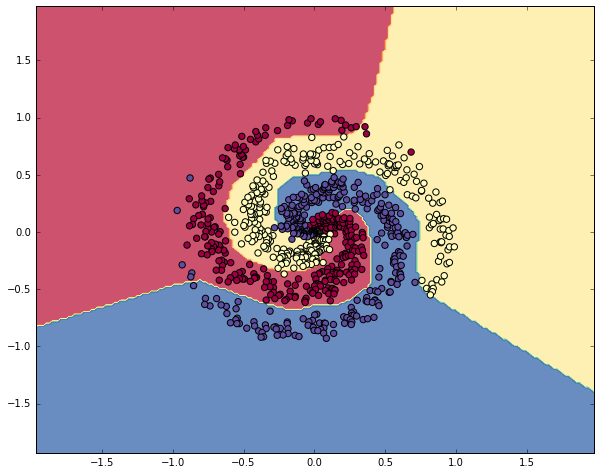

In [11]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')

In [12]:
W_NN = W
b_NN = b
W2_NN = W2
b2_NN = b2

## Step 2: Use the weights in NN
We use the weights to modify the learning rate in the stochastic gradient descent for the neural network

In [13]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-1
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in xrange(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print "iteration %d: loss %f" % (i, loss)
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  dscores = dscores*diff_level
 
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098615
iteration 1000: loss 0.851665
iteration 2000: loss 0.631307
iteration 3000: loss 0.591657
iteration 4000: loss 0.558239
iteration 5000: loss 0.556163
iteration 6000: loss 0.567556
iteration 7000: loss 0.581455
iteration 8000: loss 0.592053
iteration 9000: loss 0.599559


In [14]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.97


(-1.9292686205935685, 1.9707313794064349)

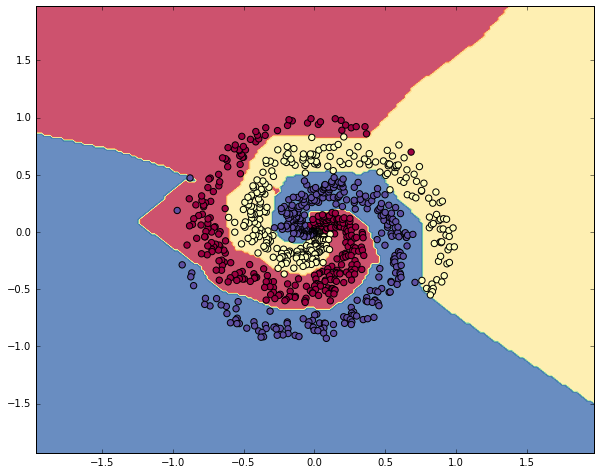

In [15]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')

In [16]:
W_NN_diff = W
b_NN_diff = b
W2_NN_diff = W2
b2_NN_diff = b2

## Testing the result over a Test set:
We generate a arbitrary test dataset, and check the performance on the same.

(-1, 1)

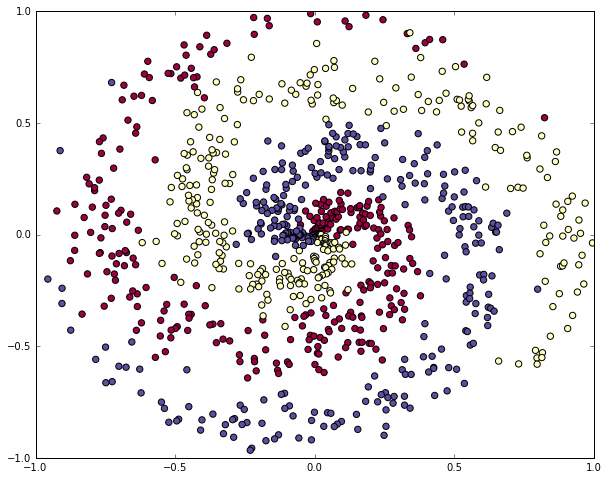

In [17]:
np.random.seed(0)
N = 300 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
rot = 1;
X = np.zeros((N*K,D))
polar = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in xrange(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = 2*np.pi*j/K + r*2*np.pi*rot + np.random.randn(N)*0.5 # theta
  polar[ix] = np.c_[r,t]
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
#fig.savefig('spiral_raw.png')

In [18]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W_NN) + b_NN)
scores = np.dot(hidden_layer, W2_NN) + b2_NN
predicted_class = np.argmax(scores, axis=1)
print 'test accuracy without LUPI: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.82


In [19]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W_NN_diff) + b_NN_diff)
scores = np.dot(hidden_layer, W2_NN_diff) + b2_NN_diff
predicted_class = np.argmax(scores, axis=1)
print 'test accuracy with LUPI: %.2f' % (np.mean(predicted_class == y))

test accuracy with LUPI: 0.93


## Conclusion
We observe a significant improvement using LUPI, an improvement from 82% to 93%.
This in some sense shows that if the priviledged information can give a good indicator of difficulty of examples/outliers then it can be very effectively used witha  simple modification of learning rate in any kind of gradient descent methods for neural networks.

However more experiments with real data is necessary to confirm which kind of priviledged classes are effective in real life scenarios

## References:
1. The base code was taken from CS231n course notes: http://cs231n.github.io/neural-networks-case-study/
2. The idea of weighted learning is motivated from: 
    [Learning to Transfer priviledged Information](http://arxiv.org/abs/1410.0389)
